In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

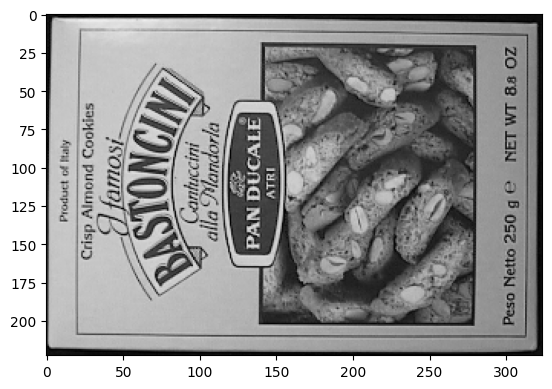

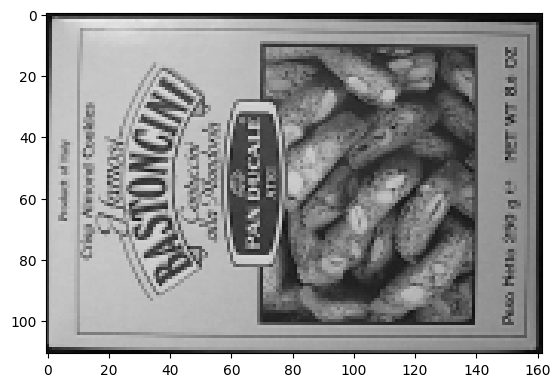

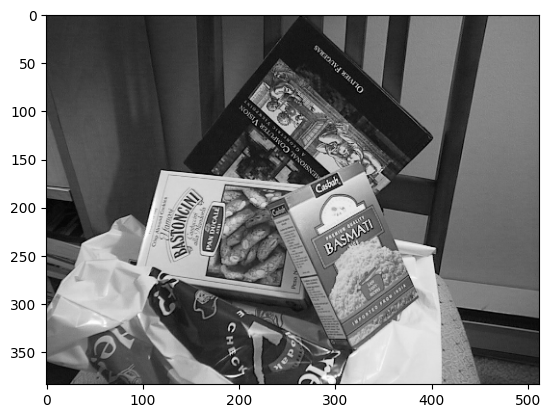

In [2]:
box=np.array(Image.open('find.png'), dtype=int)
plt.figure()
plt.imshow(box, cmap='gray', vmin=0, vmax=255)
plt.show()

def scale(image, s_resized):
    """ 
    img = np.array([[1, 2, 3, 4],
                    [5, 6, 7, 8],
                    [9, 10, 11, 12],
                    [13, 14, 15, 16]])

    array([[3, 5],
           [11, 13]])
    """
    w = image.shape[0]  
    h = image.shape[1]  

    newI = np.zeros((w//s_resized, h//s_resized), dtype=int)

    for i in range(0, w//s_resized):
        for j in range(0, h//s_resized):
            newI[i, j] = int(np.mean(image[i*s_resized:s_resized*(i+1), j*s_resized:s_resized*(j+1)]))

    return newI

box = scale(box, 2)
plt.figure()
plt.imshow(box, cmap='gray', vmin=0, vmax=255)
plt.show()

box_in_scene=np.array(Image.open('all.png'), dtype=int)
plt.figure()
plt.imshow(box_in_scene, cmap='gray', vmin=0, vmax=255)
plt.show()

In [41]:
patch_size=31

def get_circle_pixels(image, center_x, center_y):

    # Верхняя часть окружности
    top_circle = np.concatenate((
        image[center_x:center_x+2, center_y-3],      
        image[center_x+2, center_y-2:center_y-1],    
        image[center_x+3, center_y-1:center_y+2],    
        image[center_x+2, center_y+2:center_y+3],    
        image[center_x:center_x+2, center_y+3]       
    ), axis=None)
    
    # Нижняя часть окружности
    bottom_circle = np.concatenate((
        image[center_x+3, center_y:center_y+2],      
        image[center_x+2, center_y+2:center_y+3],     
        image[center_x-1:center_x+2, center_y+3],    
        image[center_x-2, center_y+2:center_y+3],    
        image[center_x-3, center_y:center_y+2]       
    ), axis=None)
    
    # Полная окружность
    full_circle = np.concatenate((
        image[center_x-1:center_x+2, center_y-3],    # Верхние точки
        image[center_x+2, center_y-2:center_y-1],    # Правые верхние 
        image[center_x+3, center_y-1:center_y+2],    # Правые точки
        image[center_x+2, center_y+2:center_y+3],    # Правые нижние 
        image[center_x-1:center_x+2, center_y+3],    # Нижние точки
        image[center_x-2, center_y+2:center_y+3],    # Левые нижние 
        image[center_x-3, center_y-1:center_y+2],    # Левые точки
        image[center_x-2, center_y-2:center_y-1]     # Левые верхние
    ), axis=None)
    
    # 9 - 9 - 16 
    return top_circle, bottom_circle, full_circle

def FAST(image, min_consecutive_pixels, intensity_threshold):
    """
    min_consecutive_pixels - минимальное число последовательных пикселей (n)
    intensity_threshold - порог интенсивности (t)
    """
    if min_consecutive_pixels < 6 or min_consecutive_pixels > 16:
        return []
    
    height, width = image.shape
    feature_points = []
    margin = patch_size // 2
    
    for y in range(margin, height - margin):
        for x in range(margin, width - margin):
            
            # Центральный пиксель
            center_pixel = image[y, x]
            
            top, bottom, full = get_circle_pixels(image, y, x)
            
            # Яркие точки
            if (all(q > center_pixel + intensity_threshold for q in top) or 
                all(q > center_pixel + intensity_threshold for q in bottom)):
                consecutive_count = 0
                for pixel in np.concatenate((full, full)):
                    if pixel > center_pixel + intensity_threshold:
                        consecutive_count += 1
                    else:
                        consecutive_count = 0
                    if consecutive_count >= min_consecutive_pixels:
                        feature_points.append((y, x))
                        break
                        
            # Темные точки
            elif (all(q < center_pixel - intensity_threshold for q in top) or 
                  all(q < center_pixel - intensity_threshold for q in bottom)):
                consecutive_count = 0
                for pixel in np.concatenate((full, full)):
                    if pixel < center_pixel - intensity_threshold:
                        consecutive_count += 1
                    else:
                        consecutive_count = 0
                    if consecutive_count >= min_consecutive_pixels:
                        feature_points.append((y, x))
                        break
                        
    return feature_points

In [42]:
fast_query = FAST(box, 12, 30)
fast_test = FAST(box_in_scene, 12, 30)
print(len(fast_query), fast_query)
print(len(fast_test), fast_test)

155 [(16, 117), (19, 40), (21, 43), (23, 43), (24, 47), (25, 46), (25, 113), (25, 137), (26, 112), (26, 113), (27, 41), (27, 45), (27, 111), (27, 112), (28, 43), (31, 44), (31, 73), (31, 113), (31, 139), (32, 51), (33, 118), (33, 119), (34, 38), (34, 41), (34, 118), (35, 40), (35, 43), (35, 76), (36, 55), (37, 54), (37, 87), (37, 113), (39, 82), (40, 37), (41, 54), (41, 83), (42, 23), (42, 24), (42, 38), (43, 68), (43, 76), (43, 81), (43, 104), (44, 59), (44, 66), (44, 67), (44, 68), (44, 76), (44, 102), (44, 103), (45, 32), (45, 47), (45, 66), (45, 76), (46, 53), (50, 15), (50, 67), (50, 68), (52, 23), (52, 31), (52, 32), (53, 115), (53, 116), (54, 22), (54, 23), (54, 73), (54, 114), (54, 115), (54, 116), (54, 139), (55, 53), (56, 22), (56, 35), (56, 124), (57, 52), (57, 53), (57, 113), (58, 21), (58, 23), (58, 51), (58, 73), (58, 120), (59, 67), (59, 73), (60, 67), (60, 68), (60, 80), (60, 92), (60, 93), (61, 33), (61, 41), (61, 84), (62, 83), (62, 84), (63, 23), (63, 38), (63, 137),

In [43]:
# Гаусс
def gaussian_kernel(sigma, size):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / (2 * np.pi * sigma**2)  
    kernel = kernel / np.sum(kernel)  # Нормализуем ядро
    return kernel

def apply_gaussian_blur(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padding_y, padding_x = kernel_height // 2, kernel_width // 2

    # Создаем пустой массив для результата
    blurred_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image_height):
        for j in range(image_width):
            sum_value = 0.0 

            for m in range(kernel_height):
                for n in range(kernel_width):
                    # Индексы для области среза
                    x = i + m - padding_y
                    y = j + n - padding_x

                    if 0 <= x < image_height and 0 <= y < image_width:
                        sum_value += image[x, y] * kernel[m, n]

            blurred_image[i, j] = sum_value

    return np.clip(blurred_image, 0, 255).astype(np.uint8)

In [44]:
def apply_filter(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padding_y, padding_x = kernel_height // 2, kernel_width // 2

    filtered_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image_height):
        for j in range(image_width):
            sum_value = 0.0 

            for m in range(kernel_height):
                for n in range(kernel_width):
                    x = i + m - padding_y
                    y = j + n - padding_x

                    if 0 <= x < image_height and 0 <= y < image_width:
                        sum_value += image[x, y] * kernel[m, n]

            filtered_image[i, j] = sum_value

    return filtered_image

def get_gradient(image):
    # Фильтры Собеля
    sobel_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])

    sobel_y = np.array([[ 1,  2,  1], 
                        [ 0,  0,  0], 
                        [-1, -2, -1]])
    
    grad_x = apply_filter(image, sobel_x)
    grad_y = apply_filter(image, sobel_y)
    
    height, width = image.shape
    gradient = np.zeros((height, width, 2), dtype=float)
    
    gradient[:,:,0] = grad_x
    gradient[:,:,1] = grad_y
    
    return gradient


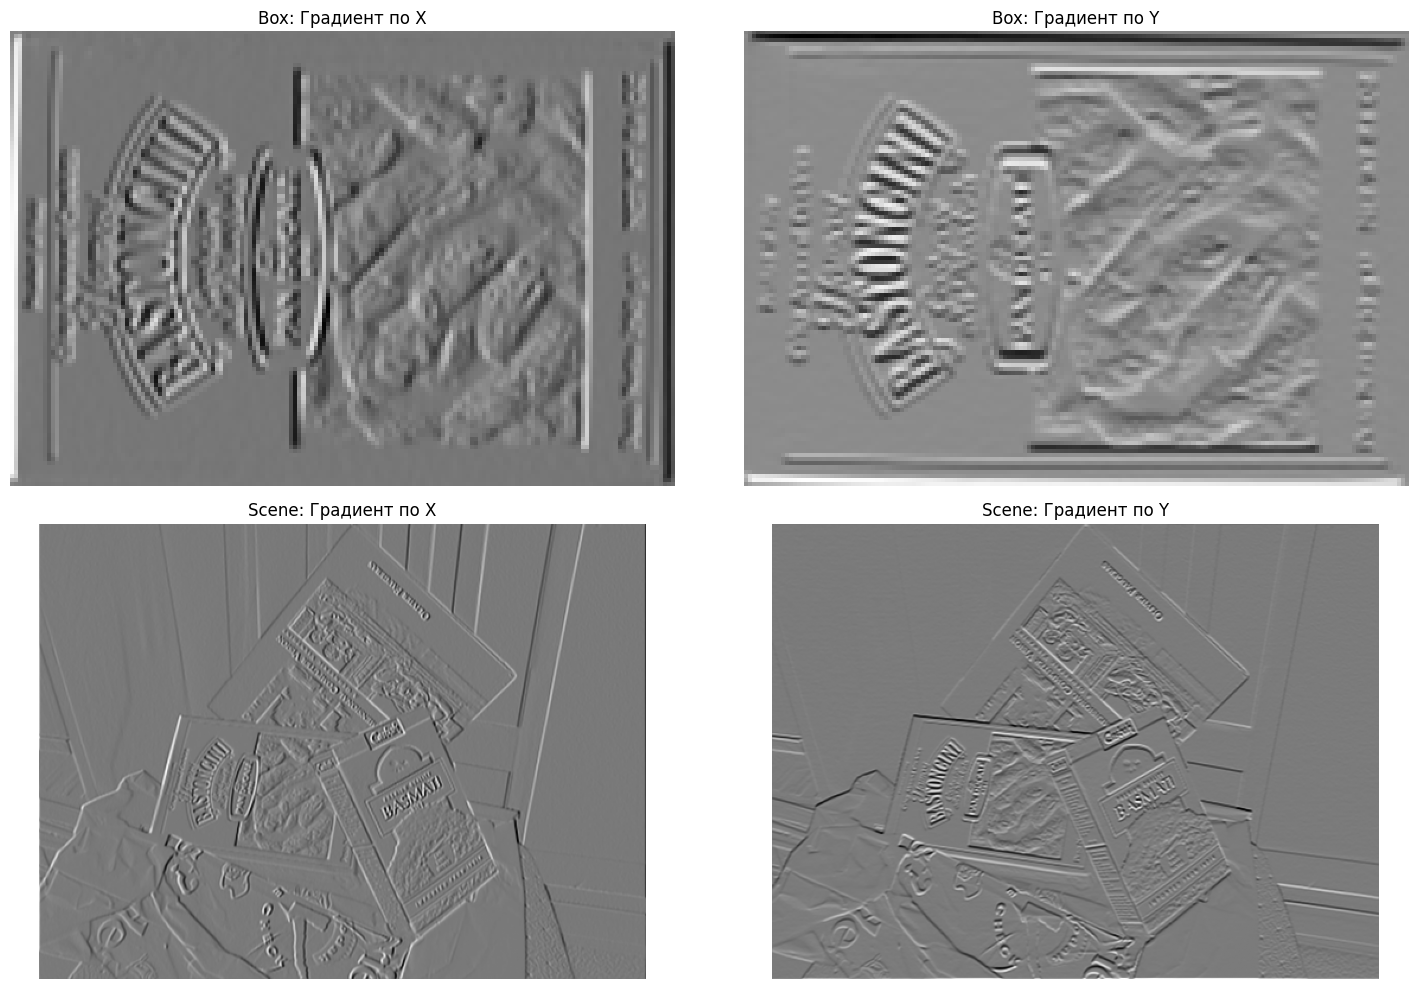

In [45]:
def visualize_gradients(gradient_query, gradient_test):
    plt.figure(figsize=(15, 10))
    
    # Градиенты для первого изображения
    plt.subplot(221)
    plt.imshow(gradient_query[:,:,0], cmap='gray')
    plt.title('Box: Градиент по X')
    plt.axis('off')
    
    plt.subplot(222)
    plt.imshow(gradient_query[:,:,1], cmap='gray')
    plt.title('Box: Градиент по Y')
    plt.axis('off')
    
    # Градиенты для второго изображения
    plt.subplot(223)
    plt.imshow(gradient_test[:,:,0], cmap='gray')
    plt.title('Scene: Градиент по X')
    plt.axis('off')
    
    plt.subplot(224)
    plt.imshow(gradient_test[:,:,1], cmap='gray')
    plt.title('Scene: Градиент по Y')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

gradient_query = get_gradient(box)
gradient_test = get_gradient(box_in_scene)
visualize_gradients(gradient_query, gradient_test)

In [46]:
def compute_M_for_points(image, gradient, feature_points):
    """
    # Матрица M:
    # [
    #     [Σ(w*dx*dx), Σ(w*dx*dy)],
    #     [Σ(w*dx*dy), Σ(w*dy*dy)]
    # ]
    """
    w, h = image.shape

    padded_image = np.zeros((w+4, h+4), dtype=int)
    padded_image[2:w+2, 2:h+2] = image
    
    W = gaussian_kernel(sigma=1, size=5)  
    
    M_matrices = []
    
    for x, y in feature_points:
        M = np.zeros((2, 2), dtype=float)
        
        # 5x5 окно
        for i in range(x-2, x+3):
            for j in range(y-2, y+3):

                Ix = gradient[i, j, 0]
                Iy = gradient[i, j, 1]

                A = np.array([[Ix**2, Ix*Iy], 
                            [Ix*Iy, Iy**2]], dtype=float)
                
                new = np.sum(W * padded_image[i:i+5, j:j+5]) * A
                
                # M и точка
                M = np.add(M, new)
                
        M_matrices.append(M)
    
    return M_matrices

In [47]:
matrix_M_query = compute_M_for_points(box, gradient_query, fast_query)
matrix_M_test = compute_M_for_points(box_in_scene, gradient_test, fast_test)

In [48]:
def compute_R_values(M_matrices, k):

    R_values = []
    for m in M_matrices:
        # R = det(M) - k * (trace(M))^2
        R = np.linalg.det(m) - k * np.trace(m)**2
        R_values.append(R)
    
    return R_values

In [49]:
k = 0.04
R_query= compute_R_values(matrix_M_query, k)
R_test = compute_R_values(matrix_M_test, k)
print(R_query)
print(R_test)

[np.float64(1214245365727021.5), np.float64(2399288221975544.0), np.float64(-2460247811991773.5), np.float64(-5754390610034778.0), np.float64(-2628303044568569.0), np.float64(-4748846321951596.0), np.float64(1.0065973552615606e+16), np.float64(2057961883695275.5), np.float64(1.4246478181461056e+16), np.float64(1.206928463600534e+16), np.float64(-1.3186811250879976e+16), np.float64(7260995952886004.0), np.float64(9264406316241504.0), np.float64(1.224960081868996e+16), np.float64(-1.0998136983269492e+16), np.float64(1.4525452697564356e+16), np.float64(5.100220218329864e+16), np.float64(590052081058020.5), np.float64(277698337830693.88), np.float64(7408418739736839.0), np.float64(1020406091710199.9), np.float64(922134375492949.6), np.float64(-1.0663210460084592e+16), np.float64(9423339109300276.0), np.float64(981334558261379.4), np.float64(-1.1371521412789038e+16), np.float64(1.7406524541183268e+16), np.float64(2931436927370966.0), np.float64(3987015125797838.0), np.float64(63030181053965

In [50]:
def Harris_filter(feature_points, R_values, max_points):

    # (точка, значение R)
    points_with_R = list(zip(feature_points, R_values))
    
    # По убыванию R
    sorted_points = sorted(points_with_R, key=lambda x: x[1], reverse=True)
    
    # Точки с положительным R
    filtered_points = []
    for point, r_value in sorted_points[:max_points]:
        if r_value < 0:
            break
        filtered_points.append(point)
        
    return filtered_points

In [51]:
points_query = Harris_filter(fast_query, R_query, 500)
points_test = Harris_filter(fast_test, R_test, 500)
print(len(points_query), points_query)
print(len(points_test), points_test)

141 [(31, 73), (67, 30), (40, 37), (42, 38), (68, 40), (79, 33), (79, 32), (70, 31), (43, 68), (88, 37), (63, 38), (44, 67), (65, 67), (44, 68), (66, 28), (59, 67), (74, 42), (60, 68), (69, 67), (35, 43), (80, 37), (75, 67), (81, 42), (81, 49), (69, 68), (31, 44), (26, 112), (61, 41), (64, 67), (75, 68), (64, 68), (79, 37), (27, 112), (60, 67), (26, 113), (70, 68), (56, 35), (45, 66), (50, 68), (44, 66), (39, 82), (25, 113), (65, 34), (50, 67), (34, 41), (27, 111), (54, 115), (82, 50), (64, 69), (73, 66), (53, 115), (32, 51), (54, 114), (27, 45), (54, 116), (45, 47), (37, 54), (53, 116), (71, 19), (66, 53), (71, 18), (60, 80), (58, 21), (46, 53), (72, 25), (71, 54), (56, 124), (65, 55), (78, 101), (63, 23), (36, 55), (41, 54), (73, 54), (77, 102), (57, 113), (50, 15), (67, 23), (58, 120), (35, 76), (58, 73), (42, 23), (88, 83), (59, 73), (55, 53), (58, 23), (57, 53), (56, 22), (19, 40), (77, 100), (73, 53), (25, 137), (62, 83), (42, 24), (71, 89), (45, 32), (41, 83), (58, 51), (60, 93)

In [52]:
def draw(image, points, color=[0, 0, 255]):

    height, width = image.shape
    
    result_image = np.zeros((height, width, 3), dtype=int)
    
    for i in range(height):
        for j in range(width):
            result_image[i, j, :] = image[i, j]
            
    for center_x, center_y in points:
        
        result_image[center_x-1:center_x+2, center_y-3] = color
        
        result_image[center_x+2, center_y-2] = color
        
        result_image[center_x+3, center_y-1:center_y+2] = color
        
        result_image[center_x+2, center_y+2] = color
        
        result_image[center_x-1:center_x+2, center_y+3] = color
        
        result_image[center_x-2, center_y+2] = color
        
        result_image[center_x-3, center_y-1:center_y+2] = color
        
        result_image[center_x-2, center_y-2] = color
        
    return result_image

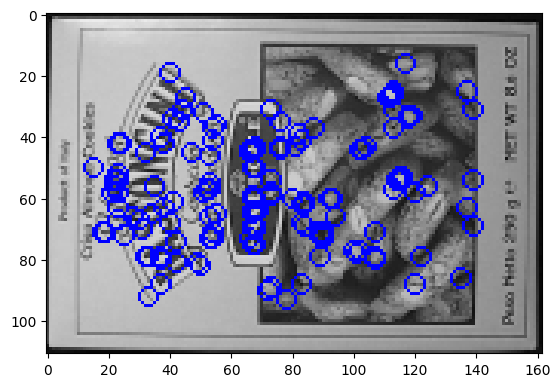

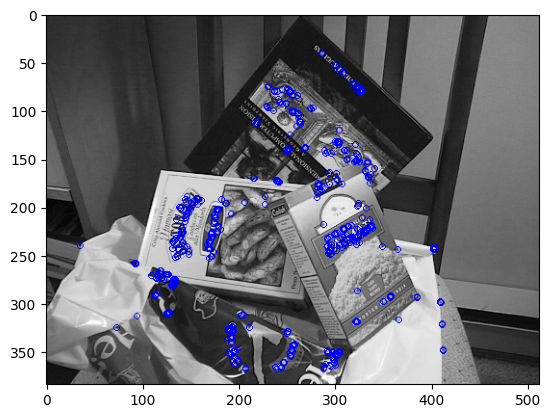

In [53]:
boxWithFeatures = draw(box, points_query)
plt.figure()
plt.imshow(boxWithFeatures, vmin=0, vmax=255)
plt.show()

boxInSceneWithFeatures = draw(box_in_scene, points_test)
plt.figure()
plt.imshow(boxInSceneWithFeatures, vmin=0, vmax=255)
plt.show()

In [54]:
# Момент изображения I в точке (x, y) 
def moments_getter(I, p, q, x, y, r):

  # I - полутоновое изображение
  # p, q - порядки центрального момента m, соответствующие координатам x, y
  # x, y - координаты
  # r - радиус окрестности точки (x, y)
  
  w = I.shape[0]
  h = I.shape[1]

  # Координаты центральной точки
  ci = w//2
  cj = h//2

  m = 0

  # Проход по окну (max и min - границы окна)
  for i in range(max(0, x-r), min(w, x+r+1)):
      for j in range(max(0, y-r), min(h, y+r+1)):
        m += (i-ci)**p * (j-cj)**q * I[i, j]
  return m

import math

# Получение углов (ориентаций) для ключевых точек
# angle = arctan2(m01, m10)
def angles_getter(I, points, r):

  angles = []
  for x, y in points:
    # Вертикальный момент m01 = Σ( (j-cj) * I[j, i] )
    m01 = moments_getter(I, 0, 1, x, y, r)
    # Горизонтальный момент m10 = Σ( (i-ci) * I[j, i] )
    m10 = moments_getter(I, 1, 0, x, y, r)
    # Угол в диапазоне [0, 2π] (без отрицательных значений)
    a = math.atan2(m01, m10) % (2*np.pi)
    angles.append(a)

  return angles

In [55]:
angles_query = angles_getter(box, points_query, patch_size)
angles_test = angles_getter(box_in_scene, points_test, patch_size)
print(angles_query)
print(angles_test)

[3.5617382151976114, 4.96072799032393, 4.354794390370131, 4.3901681662496905, 5.03716290320858, 5.179246618723269, 5.170289690639439, 5.021313309410026, 4.010039383331371, 5.288404151523533, 4.9092892713424865, 4.076547512670813, 5.269782770110683, 4.049770324276973, 4.936224121944482, 4.942971303559423, 5.180870520197628, 5.015557410546398, 5.421546897566365, 4.1996664531517505, 5.226533022039481, 5.610380475725012, 5.284234217164144, 5.3649805816715705, 5.447848089168742, 4.127522083422388, 2.3138212481343374, 4.872330397611084, 5.2229442482181145, 5.6363282890216775, 5.245758321970964, 5.218301742727144, 2.3023604907897615, 5.000972372412899, 2.2914111396295467, 5.4768843984984334, 4.7328317573291505, 4.139725922051505, 4.348198633666903, 4.100830681686963, 3.229986552883067, 2.302612012429966, 4.935762821653017, 4.365925238386895, 4.2002852385373615, 2.3262185134991897, 1.5771718562617603, 5.387360100164644, 5.271579415092748, 5.533414876088134, 1.6064584581347954, 4.04392823193430

In [56]:
def Gaussian_filtering(image_e):

    kernel = gaussian_kernel(sigma=10, size=5)  
    
    gaussImage = apply_gaussian_blur(image_e, kernel)
    
    return gaussImage

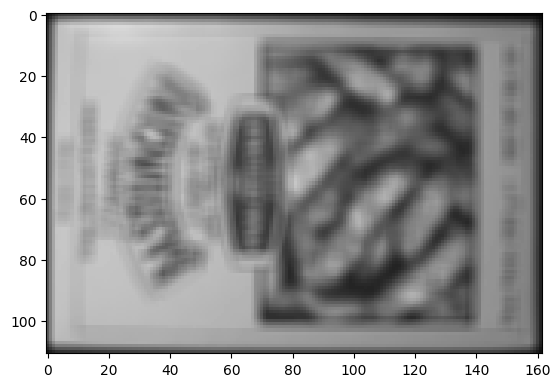

In [57]:
gaussBox = Gaussian_filtering(box)
plt.figure()
plt.imshow(gaussBox, cmap='gray', vmin=0, vmax=255)

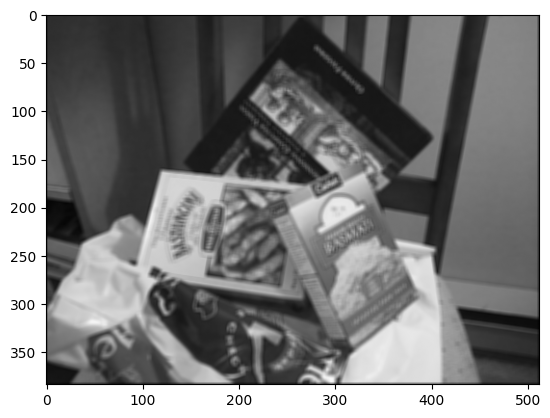

In [58]:
gaussScene = Gaussian_filtering(box_in_scene)
plt.figure()
plt.imshow(gaussScene, cmap='gray', vmin=0, vmax=255)

In [59]:
# 30 равномерно распределенных углов от 0 до 2π
angles_for_descriptor = [2*k*np.pi/30 for k in range(30)]
print(len(angles_for_descriptor), angles_for_descriptor)

# Матрица поворота для каждого угла
# |cos(θ) -sin(θ)|
# |sin(θ)  cos(θ)|
rotate_matrix = []
for t in angles_for_descriptor:
  rt = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
  rotate_matrix.append(rt)

# Случайные точки
n = 256 
random_points= (np.pi/5) * np.random.randn(n, 2, 2)

# Нормализация
random_points/= np.max(random_points)
# масштабирование до размера окна
random_points*= (patch_size//2 - 2)
print(random_points)

# Ориентации (повернутые точки)
rotated_angles = []
for rt in rotate_matrix:
  st = []
  for i in range(random_points.shape[0]):
    st.append(list(np.array([rt.dot(random_points[i, 0]), rt.dot(random_points[i, 1])], dtype=int)))
  rotated_angles.append(st)

print(rotated_angles)

30 [0.0, 0.20943951023931953, 0.41887902047863906, 0.6283185307179586, 0.8377580409572781, 1.0471975511965976, 1.2566370614359172, 1.4660765716752369, 1.6755160819145563, 1.8849555921538759, 2.0943951023931953, 2.3038346126325147, 2.5132741228718345, 2.7227136331111543, 2.9321531433504737, 3.1415926535897927, 3.3510321638291125, 3.5604716740684323, 3.7699111843077517, 3.979350694547071, 4.1887902047863905, 4.39822971502571, 4.607669225265029, 4.817108735504349, 5.026548245743669, 5.235987755982989, 5.445427266222309, 5.654866776461628, 5.8643062867009474, 6.073745796940267]
[[[-3.62360195 -0.17763176]
  [-1.52633715  1.59969617]]

 [[-3.17558113  1.36964796]
  [ 2.06833195 -1.96787479]]

 [[-6.48055035 -4.76634727]
  [-1.34004069 -5.35971109]]

 ...

 [[ 0.55472122  4.81810603]
  [ 3.24146135  1.53054939]]

 [[ 0.65184765 -4.99396964]
  [ 7.11591767 -0.61217917]]

 [[ 0.34518016 -4.80880449]
  [ 1.68383599  3.09213006]]]
[[[array([-3,  0]), array([-1,  1])], [array([-3,  1]), array([ 2

In [60]:
def get_descriptor(gaussImage, points, angles, patch_size):

    height, width = gaussImage.shape
    
    def compare_intensities(image, point1, point2):
        """
        1 если первая точка темнее, 0 иначе
        """
        intensity1 = image[point1[0], point1[1]]
        intensity2 = image[point2[0], point2[1]]
        return 1 if intensity1 < intensity2 else 0
    
    descriptors = []
    
    # Ключевые точки
    for point_idx, center_point in enumerate(points):
        # Находим индекс угла поворота
        rotation_idx = len(angles_for_descriptor) - 1
        # Ближайший меньший угол
        for angle_idx, angle in enumerate(angles_for_descriptor):
            if angles[point_idx] < angle:
                rotation_idx = angle_idx - 1
                break
        
        # Повернутые пары точек для текущего угла
        sampling_points = []
        for i in range(n):
            # смещение относительно центра
            offset_point1 = rotated_angles[rotation_idx][i][0] + center_point
            offset_point2 = rotated_angles[rotation_idx][i][1] + center_point
            sampling_points.append([offset_point1, offset_point2])
        
        # Формирование дескриптора
        binary_tests = []
        for test_points in reversed(sampling_points):
            result = compare_intensities(gaussImage, 
                                      test_points[0], 
                                      test_points[1])
            binary_tests.append(result)
            
        descriptors.append(np.array(binary_tests))
    
    return descriptors

In [61]:
descriptor_query = get_descriptor(gaussBox, points_query, angles_query, patch_size)
descriptor_test = get_descriptor(gaussScene, points_test, angles_test, patch_size)

print("Длина дескриптора query:", len(descriptor_query))
print("Длина дескриптора test:", len(descriptor_test))

Длина дескриптора query: 141
Длина дескриптора test: 500


In [62]:
def compare_descriptors(descriptor_query, descriptor_test):
    num_query_descriptors = len(descriptor_query)
    num_test_descriptors = len(descriptor_test)
    
    hamming_distances = np.zeros((num_query_descriptors, num_test_descriptors), dtype=int)
    
    for i in range(num_query_descriptors):
        for j in range(num_test_descriptors):
            
            # Дескриптор первой точки
            descriptor1 = descriptor_query[i]  

            # Дескриптор второй точки
            descriptor2 = descriptor_test[j]   
            
            distance = sum(np.absolute(descriptor1 - descriptor2))
            
            hamming_distances[i, j] = distance
            
    return hamming_distances

In [63]:
h_dist = compare_descriptors(descriptor_query, descriptor_test)
print(h_dist)

[[113 106 144 ... 127 166 168]
 [132 129 163 ... 146 163 161]
 [137 106 132 ... 125 128 124]
 ...
 [123 130 178 ... 153 178 174]
 [146 145  93 ... 100  71  67]
 [152 153  91 ...  82  83  79]]


In [64]:
def Lowe_test(points1, points2, hamming_distances):

    LOWE_RATIO = 0.8 
    height, width = hamming_distances.shape
    
    matches_forward = []  # прямой поиск (1→2)
    matches_backward = [] # обратный поиск (2→1)
    
    # Прямой поиск (для каждой точки первого изображения)
    for i in range(height):
        # Порядок возврастания расстояний Хэмминга
        # строка
        distances = sorted(hamming_distances[i])
        
        # Проверяем первые два ближайших соответствия
        for t in range(len(distances)-1):
            dist1, dist2 = distances[t:t+2]  # два ближайших расстояния
            ratio = dist1/dist2  
            
            if ratio < LOWE_RATIO:
                # Находим индекс точки с минимальным расстоянием
                match_idx = list(hamming_distances[i]).index(dist1)
                # Пара точек -> соответствие 
                matches_forward.append([points1[i], points2[match_idx]])
                break
    
    # Обратный поиск (для каждой точки второго изображения)
    for i in range(width):
        # столбец
        distances = sorted(hamming_distances[:, i])
        for t in range(len(distances)-1):
            dist1, dist2 = distances[t:t+2]
            ratio = dist1/dist2
            
            if ratio < LOWE_RATIO:
                match_idx = list(hamming_distances[:, i]).index(dist1)
                matches_backward.append([points1[match_idx], points2[i]])
                break
    
    return [matches_forward, matches_backward]

In [65]:
Lowe_distances = Lowe_test(points_query, points_test, h_dist)
print(len(Lowe_distances[0]), len(Lowe_distances[1]))
print(Lowe_distances)

16 61
[[[(31, 73), (195, 206)], [(79, 33), (243, 131)], [(79, 32), (243, 131)], [(88, 37), (252, 134)], [(69, 67), (237, 169)], [(80, 37), (244, 137)], [(75, 67), (243, 168)], [(81, 42), (246, 141)], [(81, 49), (246, 148)], [(69, 68), (237, 170)], [(79, 37), (243, 137)], [(64, 69), (231, 172)], [(73, 66), (239, 167)], [(53, 116), (283, 131)], [(72, 25), (244, 365)], [(54, 23), (171, 302)]], [[(81, 49), (259, 93)], [(42, 23), (201, 139)], [(88, 37), (252, 134)], [(69, 67), (211, 175)], [(75, 67), (243, 168)], [(82, 50), (258, 93)], [(56, 124), (358, 298)], [(79, 32), (243, 131)], [(69, 67), (80, 253)], [(80, 37), (244, 138)], [(69, 67), (235, 170)], [(69, 67), (237, 169)], [(80, 37), (244, 137)], [(80, 37), (243, 137)], [(54, 139), (165, 293)], [(35, 43), (226, 141)], [(26, 112), (141, 310)], [(35, 43), (226, 142)], [(64, 68), (232, 172)], [(79, 107), (141, 289)], [(73, 66), (239, 167)], [(81, 42), (246, 141)], [(58, 120), (237, 315)], [(88, 120), (77, 323)], [(27, 111), (141, 309)], [(

In [66]:
def cross_check(lowe_matches):

    filtered_points1 = []  # первое изображение
    filtered_points2 = []  # второе изображение
    
    # Верхний цикл - прямые соответствия
    for i in range(len(lowe_matches[0])):
        point1, point2 = lowe_matches[0][i]  # точки прямого соответствия
        
        # Эта же пара в обратных соответствиях
        for j in range(len(lowe_matches[1])):
            point1_reverse, point2_reverse = lowe_matches[1][j]
            
            # В обоих направлениях есть эта пара
            if point1 == point1_reverse and point2 == point2_reverse:
                filtered_points1.append(point1)
                filtered_points2.append(point2)
                break
    
    return [filtered_points1, filtered_points2]

In [67]:
cross_distances = cross_check(Lowe_distances)
print(len(cross_distances[0]), len(cross_distances[1]))
print(cross_distances)

10 10
[[(79, 32), (88, 37), (69, 67), (80, 37), (75, 67), (81, 42), (81, 49), (64, 69), (73, 66), (72, 25)], [(243, 131), (252, 134), (237, 169), (244, 137), (243, 168), (246, 141), (246, 148), (231, 172), (239, 167), (244, 365)]]


In [68]:
def bresenham(x0, y0, x1, y1, max_size):

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    
    step_x = 1 if x0 < x1 else -1
    step_y = 1 if y0 < y1 else -1
    
    error = dx - dy
    
    line_points = []
    x, y = x0, y0
    
    while True:
        if 0 <= x < max_size and 0 <= y < max_size:
            line_points.append([x, y])
            
        if x == x1 and y == y1:
            break
            
        error2 = error * 2
        
        if error2 > -dy:
            error -= dy
            x += step_x
            
        if error2 < dx:
            error += dx
            y += step_y
    
    return line_points

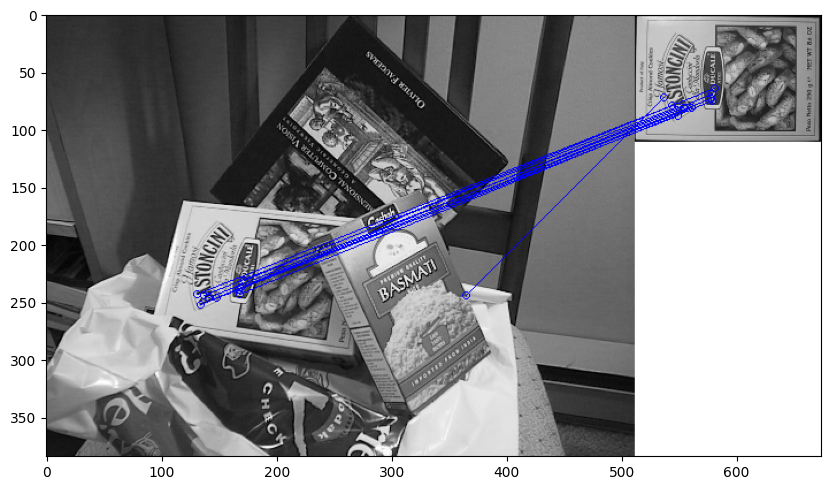

In [69]:
points1, points2 = cross_distances

def visualize_matches(image1, image2, points1, points2):

    img1_with_points = draw(image1, points1)
    img2_with_points = draw(image2, points2)
    
    # Размеры для объединенного изображения
    total_width = img1_with_points.shape[1] + img2_with_points.shape[1]
    height = img2_with_points.shape[0]
    width2 = img2_with_points.shape[1]
    
    result = np.ones((height, total_width, 3), dtype=int) * 255
    
    result[0:img2_with_points.shape[0], 0:width2] = img2_with_points
    result[0:img1_with_points.shape[0], width2:] = img1_with_points
    
    color = [0, 0, 255]  
    for i in range(len(points1)):
        x1, y1 = points1[i]
        y1 += width2  
        x2, y2 = points2[i]
        
        line_points = bresenham(x1, y1, x2, y2, total_width)
        
        for x, y in line_points:
            result[x, y] = color
            
    return result


result = visualize_matches(box, box_in_scene, points1, points2)
plt.figure(figsize=(10, 8))
plt.imshow(result, vmin=0, vmax=255)
plt.show()

In [70]:
# Нахождение матрицы афинного преобразования и вектора смещения
# Оценка параметров через СЛАУ
def get_affine_transformation_parameters(src_points, dst_points):
    """

    src_points - три точки исходного изображения [(x1,y1), (x2,y2), (x3,y3)]
    dst_points - три соответствующие точки целевого изображения [(u1,v1), (u2,v2), (u3,v3)]
    
    T - вектор переноса
    M - матрица поворота и масштаба
    """

    src = np.array(src_points)  # исходные точки
    dst = np.array(dst_points)  # целевые точки
    
    x1, y1 = src[0]  
    x2, y2 = src[1]  
    x3, y3 = src[2]  
    
    u1, v1 = dst[0]  
    u2, v2 = dst[1]  
    u3, v3 = dst[2]  
    
    # определитель первой матрицы
    det1 = (x1-x3)*(y1-y2) - (x1-x2)*(y1-y3)
    # определитель второй матрицы
    det2 = y1-y2                               
    
    if abs(det1) < 1e-10 or abs(det2) < 1e-10:
        return None, None
    
    # [u] = [m1 m2] [x] + [tx]
    # [v] = [m3 m4] [y] + [ty]

    # u = m1*x + m2*y + tx
    # v = m3*x + m4*y + ty

    # Для каждой u (пример):
    # u1 = m1*x1 + m2*y1 + tx 
    # u2 = m1*x2 + m2*y2 + tx  
    # u3 = m1*x3 + m2*y3 + tx 

    # Метод Крамера 
    # (1)-(3): u1-u3 = m1(x1-x3) + m2(y1-y3) 
    # (1)-(2): u1-u2 = m1(x1-x2) + m2(y1-y2) 

    # Матрица коэффициентов
    # A1 = | u1-u3  y1-y3 |
    #      | u1-u2  y1-y2 |

    # Нахождение неизвестной
    # m1 = ((u1-u3)(y1-y2) - (u1-u2)(y1-y3)) / det1

    try:
        m1 = ((u1-u3)*(y1-y2) - (u1-u2)*(y1-y3)) / det1
        m2 = ((u1-u2) - m1*(x1-x2)) / det2
        tx = u1 - m1*x1 - m2*y1  
        
        m3 = ((v1-v3)*(y1-y2) - (v1-v2)*(y1-y3)) / det1
        m4 = ((v1-v2) - m3*(x1-x2)) / det2
        ty = v1 - m3*x1 - m4*y1  
        
        M = np.array([[m1, m2], [m3, m4]])  
        T = np.array([tx, ty])             
        
        return M, T
        
    except:
        return None, None

In [71]:
def Affine_transformation(points, M, T):

    M = np.array(M)         
    T = np.array(T)         
    points = np.array(points) 
    
    x = points[:, 0]  
    y = points[:, 1]  
    

    # x' = m11*x + m12*y + tx
    # y' = m21*x + m22*y + ty
    x_new = M[0][0] * x + M[0][1] * y + T[0]  
    y_new = M[1][0] * x + M[1][1] * y + T[1]  
    
    # Преобразованные координаты -> массив точек
    return np.column_stack((x_new, y_new))

In [72]:
# Оценка параметров афинного преобразования методом наименьших квадратов
def MNK(points):
    """    
    Система уравнений для каждой пары точек (x,y) -> (u,v):
    u = m1*x + m2*y + tx
    v = m3*x + m4*y + ty
    
    Матричная форма A*X = B
    A = [x y 0 0 1 0] для u
        [0 0 x y 0 1] для v
    X = [m1 m2 m3 m4 tx ty]^T
    B = [u v]^T
    """
    if len(points) < 3:
        print("Недостаточно точек")
        return None, None

    A = []  # матрица коэффициентов
    B = []  # вектор значений
    for (x, y), (u, v) in points:
        # Уравнение для u
        A.append([x, y, 0, 0, 1, 0])
        B.append(u)
        # Уравнение для v
        A.append([0, 0, x, y, 0, 1])
        B.append(v)

    A = np.array(A, dtype=np.float64)
    # Массив [u1,v1,u2,v2,...] -> столбец [[u1],[v1],[u2],[v2],...]
    B = np.array(B, dtype=np.float64).reshape(-1, 1)

    # Решение МНК: X = (A^T * A)^(-1) * A^T * B
    X = np.linalg.inv(A.T @ A) @ A.T @ B

    # матрица M и вектор T
    M = X[0:4].reshape(2, 2)  
    T = X[4:6].reshape(2, 1)  
    
    return M, T

In [73]:
import random


def RANSAC(points1, points2, num_iterations, distance_threshold):
    """    
    points1, points2 - соответствующие точки двух изображений
    num_iterations: количество итераций
    distance_threshold: порог
    """
    min_points = 3  # минимальное количество точек для аффинного преобразования
    
    # Проверка количества точек
    if len(points1) < min_points:
        return None, None
    
    # Инициализация лучших параметров
    best_inliers_count = -1
    total_points = len(points1)
    best_matching_points = []
    best_transform_matrix = None
    best_translation = None
    
    try:
        # Цикл N итераций
        for _ in range(num_iterations):

            # Случайное множество сопоставленных точек (по минимальному количеству)
            random_indices = random.sample(range(len(points1)), min_points)
            sample_points1 = [points1[i] for i in random_indices]
            sample_points2 = [points2[i] for i in random_indices]
            
            # Оценка параметров через СЛАУ
            transform_matrix, translation = get_affine_transformation_parameters(
                sample_points1, sample_points2
            )
            if transform_matrix is None or translation is None:
                continue
            
            # Преобразование точек
            transformed_points = Affine_transformation(points1, transform_matrix, translation)
            
            # Подсчет верных соответствий (inliers)
            current_matching_points = []
            inliers_count = 0
            
            # Нахождение не-выбросов (inliers) по порогу расстояния
            for idx in range(len(points2)):
                x_transformed, y_transformed = transformed_points[idx]
                x_target, y_target = points2[idx]
                
                # Проверка расстояния
                if (abs(x_transformed - x_target) < distance_threshold and 
                    abs(y_transformed - y_target) < distance_threshold):
                    x_source, y_source = points1[idx]
                    inliers_count += 1
                    # Пара точек исходная -> целевая
                    current_matching_points.append([[x_source, y_source], 
                                                 [x_target, y_target]])
            
            # Обновление лучшего результата
            # Все точки совпали - идеальный случай
            if inliers_count == total_points:
                best_matching_points = current_matching_points
                best_transform_matrix = transform_matrix
                best_translation = translation
                break
            
            # Обновление лучшего результата (если больше inliers)
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_matching_points = current_matching_points
                best_transform_matrix = transform_matrix
                best_translation = translation
        
        # Финальное уточнение методом наименьших квадратов
        if best_matching_points:
            best_transform_matrix, best_translation = MNK(best_matching_points)
            
        return best_transform_matrix, best_translation
    
    except Exception as e:
        print(f"Ошибка RANSAC: {str(e)}")
        return None, None

In [74]:
M, T = RANSAC(cross_distances[0], cross_distances[1], 5, 2)
print(M)
print(T)

[[ 0.9923854   0.09705404]
 [-0.22755984  1.01171309]]
[[161.22521062]
 [116.95088761]]


In [75]:
def detect_query(box, scene, transform_matrix, translation):

    height, width = box.shape
    
    object_points = []
    for y in range(height):
        for x in range(width):
            object_points.append([y, x])
    
    transformed_points = Affine_transformation(
        object_points, 
        transform_matrix, 
        translation
    )

    polygon_points = np.array(transformed_points, dtype=int)
    
    if len(scene.shape) == 2:
        # Приведение к RGB
        result_scene = np.stack([scene] * 3, axis=-1)
    else:
        result_scene = scene.copy()
    
    scene_height, scene_width = result_scene.shape[:2]
    for point in polygon_points:
        y, x = point
        if 0 <= y < scene_height and 0 <= x < scene_width:
            result_scene[y, x] = [255, 0, 0]  
            
    return result_scene

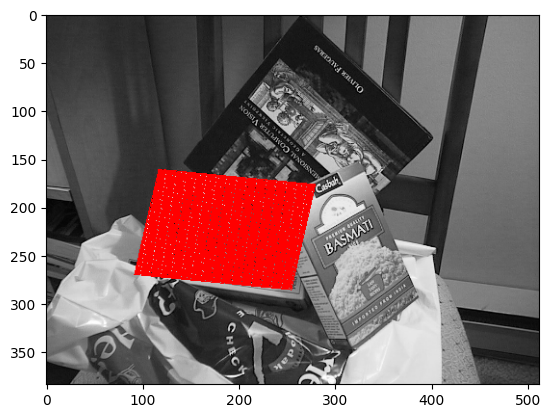

In [76]:
detected_query = detect_query(box, box_in_scene, M, T)

plt.figure()
plt.imshow(detected_query, cmap='gray', vmin=0, vmax=255)